# Imports

In [90]:
import os
import numpy as np
import keras
import tensorflow as tf
from tensorflow import set_random_seed
set_random_seed(404)
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
import itertools

from time import strftime

from IPython.display import display
from keras.preprocessing.image import array_to_img

import matplotlib.pyplot as plt

# Constants

In [3]:
LOG_DIR = 'tensorboard_cifar_logs/'

LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
VALIDATION_SIZE = 10000

# Get Data

In [4]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

# Explore the data

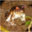

In [5]:
# Array of Array not == Image, you have to tell it to
# treat the array of array like image

pic = array_to_img(x_train_all[0])
display(pic)

In [6]:
LABEL_NAMES[y_train_all[0][0]]

'Frog'

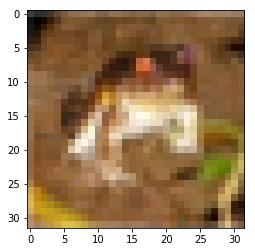

In [81]:
plt.imshow(pic)
plt.show()

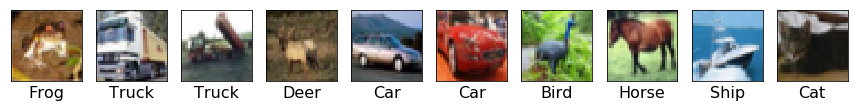

In [8]:
plt.figure(figsize=(15,5))

for i in range(10):
    plt.subplot(1,10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]], fontsize=16)
    plt.imshow(x_train_all[i])
    
plt.show()

In [9]:
nr_images, x, y, c = x_train_all.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 50000 	| width = 32 	| height = 32 	| channels = 3


# Preprocess Data

In [10]:
x_train_all, x_test = x_train_all / 255.0, x_test / 255.0 

# Prepare feature matrix

In [11]:
# Organise the records and features in a table, one row one record
x_train_all = x_train_all.reshape(x_train_all.shape[0], TOTAL_INPUTS)

# Split training, validation & testing dataset

In [12]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]

In [13]:
x_val.shape

(10000, 3072)

In [14]:
y_val.shape

(10000, 1)

In [15]:
x_train = x_train_all[VALIDATION_SIZE:]
y_train = y_train_all[VALIDATION_SIZE:]

In [16]:
x_train.shape

(40000, 3072)

In [17]:
y_train.shape

(40000, 1)

# Define the Neural Network Using Keras

In [18]:
model_1 = Sequential([
    Dense(input_dim=TOTAL_INPUTS, units=128, activation='relu',name='hidden_1'),
    Dense(units=64, activation='relu', name='hidden_2'),
    Dense(units=16, activation='relu', name='hidden_3'),
    Dense(units=10, activation='softmax', name='output')
])

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
type(model_1)

keras.engine.sequential.Sequential

# Compile the model

In [20]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 128)               393344    
_________________________________________________________________
hidden_2 (Dense)             (None, 64)                8256      
_________________________________________________________________
hidden_3 (Dense)             (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Remember that there is bias in every neuron
total_params = 32*32*3*128+ 128 + 128*64 + 64 + 64*16 + 16 + 16*10 + 10

# Tensorboard (visualized learning)

In [23]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} at { strftime("%H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        # Failure handler
        print(err.strerror)
    else:
        # Success handler
        print('Successfully created directory')
        
    return TensorBoard(log_dir=dir_paths)

# Fitting the Keras Model

In [24]:
samples_per_batch = 1000

In [25]:
%%time
nr_epochs = 150
model_1.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard("model_1")], verbose=0)

#model_1.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            #callbacks=[get_tensorboard("model_1")], verbose=0, validation_data=(x_val, y_val))

# Tensorboard will obtain data from the model that is currently being fitted
# Callbacks will be called whenever an epoch is
# Validation data is just another training data

Successfully created directory
CPU times: user 13min 2s, sys: 2min, total: 15min 2s
Wall time: 6min 41s


# 2nd model with Dropout layer to reduce overfitting

In [26]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,))) # now dropout is the first layer after input
model_2.add(Dense(units=128, activation='relu',name='hidden_1'))
model_2.add(Dense(units=64, activation='relu', name='hidden_2'))
model_2.add(Dense(units=16, activation='relu', name='hidden_3'))
model_2.add(Dense(units=10, activation='softmax', name='output'))

In [27]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 3072)              0         
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               393344    
_________________________________________________________________
hidden_2 (Dense)             (None, 64)                8256      
_________________________________________________________________
hidden_3 (Dense)             (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


# Compile the model

In [28]:
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model

In [29]:
%%time
samples_per_batch = 1000
nr_epochs = 150

model_2.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard("model_2")], verbose=1, validation_data=(x_val, y_val))

Successfully created directory
Train on 40000 samples, validate on 10000 samples
Epoch 1/150
40000/40000 [==============================] - 5s 133us/step - loss: 2.2414 - accuracy: 0.1675 - val_loss: 2.1189 - val_accuracy: 0.2255
Epoch 2/150
40000/40000 [==============================] - 4s 112us/step - loss: 2.0815 - accuracy: 0.2384 - val_loss: 2.0237 - val_accuracy: 0.2534
Epoch 3/150
40000/40000 [==============================] - 4s 107us/step - loss: 1.9984 - accuracy: 0.2722 - val_loss: 1.9604 - val_accuracy: 0.2791
Epoch 4/150
40000/40000 [==============================] - 5s 118us/step - loss: 1.9311 - accuracy: 0.2917 - val_loss: 1.8890 - val_accuracy: 0.3121
Epoch 5/150
40000/40000 [==============================] - 5s 119us/step - loss: 1.8723 - accuracy: 0.3155 - val_loss: 1.8225 - val_accuracy: 0.3389
Epoch 6/150
40000/40000 [==============================] - 4s 111us/step - loss: 1.8206 - accuracy: 0.3386 - val_loss: 1.7694 - val_accuracy: 0.3599
Epoch 7/150
40000/40000 [

# 3rd model with Dropout layer in hidden layer to reduce overfitting

In [30]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(units=128, activation='relu',name='hidden_1'))
model_3.add(Dropout(0.2, seed=42))
model_3.add(Dense(units=64, activation='relu', name='hidden_2'))
model_3.add(Dropout(0.2, seed=42))
model_3.add(Dense(units=16, activation='relu', name='hidden_3'))
model_3.add(Dropout(0.2, seed=42))
model_3.add(Dense(units=10, activation='softmax', name='output'))

In [31]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 3072)              0         
_________________________________________________________________
hidden_1 (Dense)             (None, 128)               393344    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
hidden_3 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)               

# Compile the model

In [32]:
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model

In [33]:
%%time
samples_per_batch = 1000
nr_epochs = 150

model_3.fit(x_train, y_train, batch_size=samples_per_batch, epochs=nr_epochs, 
            callbacks=[get_tensorboard("model_3")], verbose=1, validation_data=(x_val, y_val))

Successfully created directory
Train on 40000 samples, validate on 10000 samples
Epoch 1/150
40000/40000 [==============================] - 6s 153us/step - loss: 2.3210 - accuracy: 0.1014 - val_loss: 2.3028 - val_accuracy: 0.0975
Epoch 2/150
40000/40000 [==============================] - 4s 106us/step - loss: 2.2815 - accuracy: 0.1332 - val_loss: 2.2303 - val_accuracy: 0.1933
Epoch 3/150
40000/40000 [==============================] - 4s 103us/step - loss: 2.2144 - accuracy: 0.1828 - val_loss: 2.1273 - val_accuracy: 0.2386
Epoch 4/150
40000/40000 [==============================] - 4s 103us/step - loss: 2.1332 - accuracy: 0.2177 - val_loss: 2.0242 - val_accuracy: 0.2693
Epoch 5/150
40000/40000 [==============================] - 4s 103us/step - loss: 2.0662 - accuracy: 0.2382 - val_loss: 1.9472 - val_accuracy: 0.3039
Epoch 6/150
40000/40000 [==============================] - 4s 103us/step - loss: 2.0102 - accuracy: 0.2602 - val_loss: 1.8949 - val_accuracy: 0.3365
Epoch 7/150
40000/40000 [

# Model Evaluation

In [37]:
x_val[0].shape

(3072,)

In [40]:
test = np.expand_dims(x_val[0], axis=0)

In [52]:
model_3.predict(test)

array([[0.01865949, 0.02244358, 0.11663625, 0.15616919, 0.12277231,
        0.12803596, 0.34553438, 0.05841102, 0.00658637, 0.02475146]],
      dtype=float32)

In [53]:
np.set_printoptions(precision=3)

In [54]:
model_3.predict(test)

array([[0.019, 0.022, 0.117, 0.156, 0.123, 0.128, 0.346, 0.058, 0.007,
        0.025]], dtype=float32)

In [55]:
model_3.predict_classes(test)

array([6])

In [60]:
prediction_res = []
actual_res = []

for i in range(10):
    test = np.expand_dims(x_val[i], axis=0)
    prediction = model_3.predict_classes(test)[0]
    actual = y_val[i][0]
    prediction_res.append(prediction)
    actual_res.append(actual)
    print(f'Predicted result: {prediction} vs Actual result: {actual}')

Predicted result: 6 vs Actual result: 6
Predicted result: 1 vs Actual result: 9
Predicted result: 9 vs Actual result: 9
Predicted result: 6 vs Actual result: 4
Predicted result: 8 vs Actual result: 1
Predicted result: 9 vs Actual result: 1
Predicted result: 4 vs Actual result: 2
Predicted result: 7 vs Actual result: 7
Predicted result: 8 vs Actual result: 8
Predicted result: 9 vs Actual result: 3


# Evaluation

In [73]:
model_3.metrics_names

['loss', 'accuracy']

In [70]:
# Organise the records and features in a table, one row one record
x_test = x_test.reshape(x_test.shape[0], TOTAL_INPUTS)
x_test.shape
y_test.shape

(10000, 1)

In [74]:
test_loss, test_accuracy =  model_3.evaluate(x_test, y_test)
print(f'Test loss is {test_loss} and Test accuracy {test_accuracy}')

10000/10000 [==============================] - 1s 131us/step
Test loss is 1.5395810390472413 and Test accuracy 0.4521999955177307


In [75]:
predictions = model_3.predict_classes(x_test)

# Confusion Matrix

In [78]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

In [95]:
conf_matrix

array([[490,  48,  32,  36,  54,   4,  37,  30, 181,  88],
       [ 29, 561,   1,  31,  18,   9,  27,  26,  81, 217],
       [ 99,  28, 115,  96, 303,  66, 185,  53,  28,  27],
       [ 25,  20,  30, 229,  79, 233, 241,  51,  31,  61],
       [ 66,  10,  39,  66, 465,  33, 216,  60,  23,  22],
       [ 14,  10,  46, 172, 106, 347, 175,  59,  32,  39],
       [  4,  14,  11,  70, 169,  38, 644,  15,  11,  24],
       [ 39,  19,  28,  69, 149,  84,  68, 459,  15,  70],
       [ 90,  76,   5,  25,  15,  22,  16,  16, 636,  99],
       [ 39, 179,   2,  33,  12,  13,  44,  40,  62, 576]])

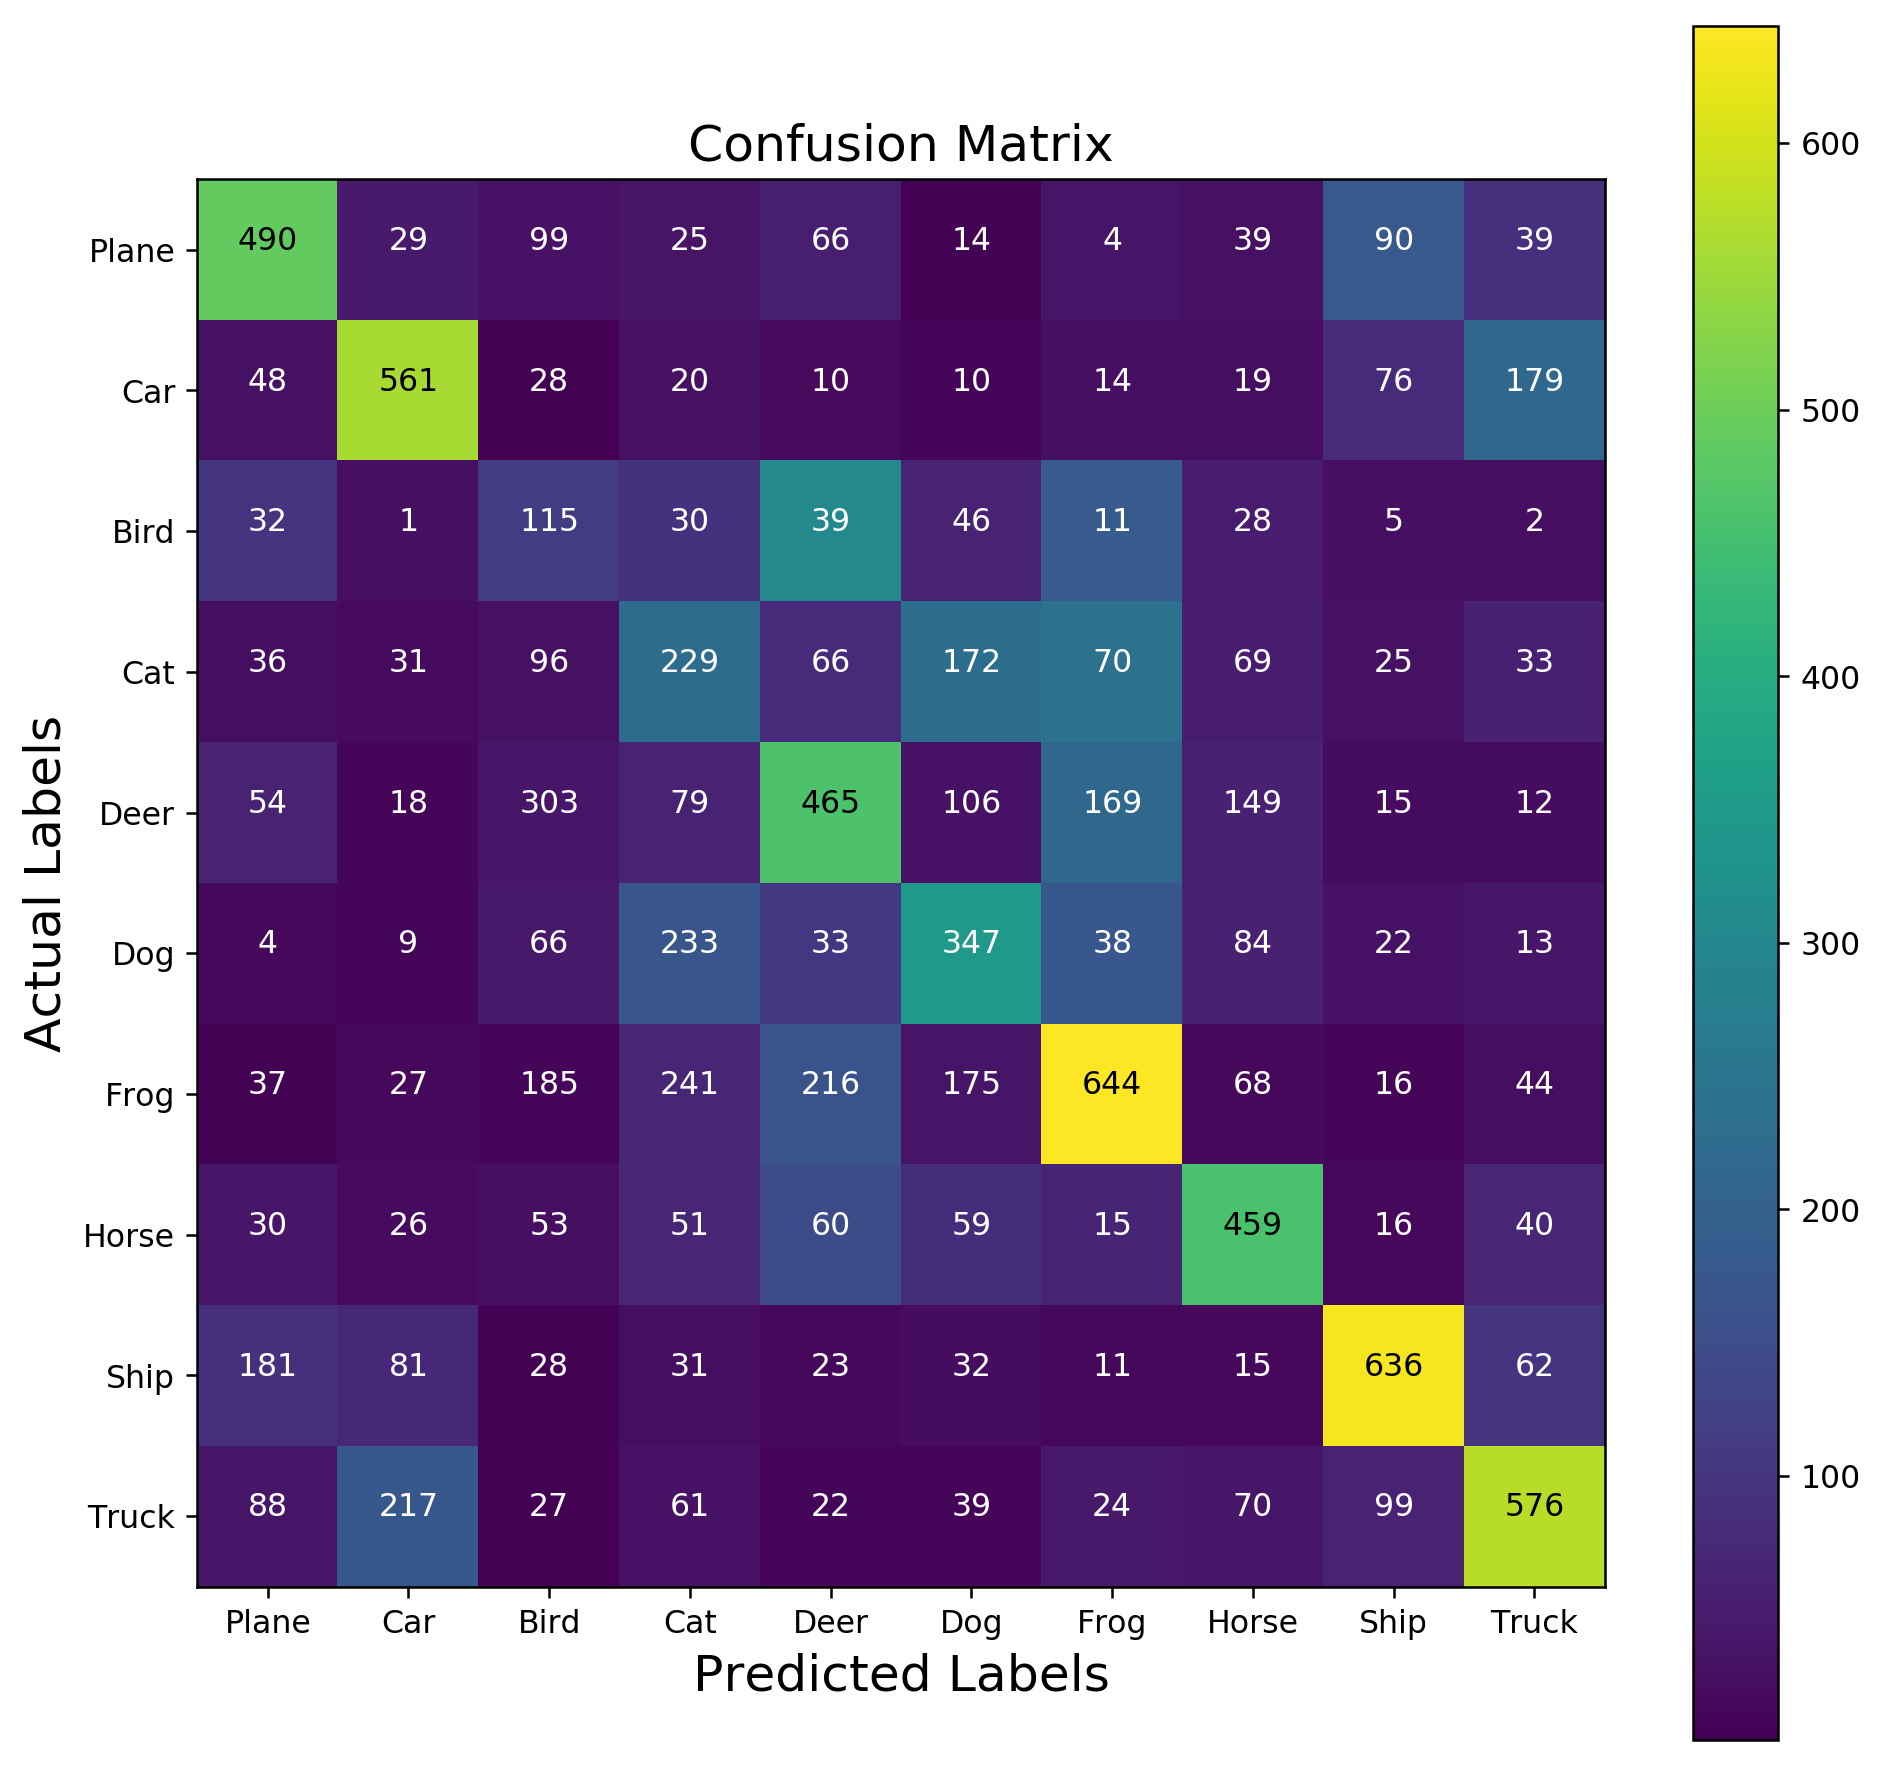

In [104]:
plt.figure(figsize=(10,10),dpi=227)
plt.imshow(conf_matrix)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('Actual Labels', fontsize=16)

tick_marks = np.arange(10)
plt.xticks(tick_marks, LABEL_NAMES)
plt.yticks(tick_marks, LABEL_NAMES)

plt.colorbar()

for i, j in itertools.product(range(10), range(10)):
    plt.text(i,j, conf_matrix[i,j], horizontalalignment='center', color='black' if conf_matrix[i,j] > 400 else 'white')

plt.show()

In [105]:
# True Positive: Diagonal Values
# False Positive: Sum of column except diagonal
# False Negative: Sum of rows except diagonal

In [109]:
# R-score
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.49 , 0.561, 0.115, 0.229, 0.465, 0.347, 0.644, 0.459, 0.636,
       0.576])

In [111]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.547, 0.581, 0.372, 0.277, 0.339, 0.409, 0.39 , 0.567, 0.578,
       0.471])

In [113]:
avg_recall = np.mean(recall)
print(f'Model 2 recall score is {avg_recall:.2%}')

Model 2 recall score is 45.22%


In [114]:
avg_precision = np.mean(precision)
print(f'Model 2 recall score is {avg_precision:.2%}')

Model 2 recall score is 45.32%


In [125]:
f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) 
print(f'Model 2 f1 score is {f1_score:.2%}')

Model 2 f1 score is 45.27%
